# First Assignment - FINTECH 540 - Machine Learning for FinTech

In this assignment, you will gain hands-on experience applying linear models to financial market data. Specifically, you will work with time series prices of the 30 constituents of the *Dow Jones Industrial Average (DJIA)* Index. The dataset covers the period from June $2^{nd}$, 2017, through June $2^{nd}$, 2023. The price series of the ETF associated with the DJIA index is also provided, whose symbol is *DIA*. The dataset is uploaded on Sakai in the same place where you found this notebook.

You will deal with three consecutive tasks, so in general, you can only perform a task if you have solved the previous one. You can obtain at most 100 points for this home assignment. The tasks are briefly summarized below, and you can find the relative prompt in each subsection of this notebook:
- Build descriptive linear models (CAPM) for all the index constituents (*20 points*).
- Select a subset of constituents and fit a predictive linear model to forecast the index value (*40 points*).
- Repeat the linear modeling exercise using boostrapped returns (*40 points*).

## About this notebook

You only need to write the final code between the `### START CODE HERE ###` and `### END CODE HERE ###` comments. You can create more cells to experiment with and prepare your final code at your convenience. Remember to put the final version of the code where it is asked. Before submitting, remember to fully run your notebook from the start to the end to ensure that there will be no runtime error. Avoiding following such guidelines will result in a decrease in the total points.

## Task 1 - Build descriptive linear models (CAPM) for all the index constituents (*20 points*)

The Capital Asset Pricing Model (CAPM) is represented as:

$$R_i - R_f =   \beta_i (R_m - R_f) + e_i$$

Where:
- $R_i$ is the return of the asset or security $i$.
- $R_f$ is the risk-free rate, representing the return on a risk-free investment.
- $\beta_i$ is the beta of the asset $i$, which measures its sensitivity to market movements.
- $R_m$ is the market portfolio's return (the index).
- $e_i$ is the error term or residual representing unexplained variation in the asset's return.

The CAPM equation helps estimate the return of an asset based on its risk relative to the market and the risk-free rate. You can calculate the daily risk-free rate by using the following formula.

$$ r_{\text{daily}} = \left(1 + r_{\text{annual}}\right)^{\frac{1}{365}} - 1 $$

Where:
- $r_{\text{daily}}$ is the daily yield. It represents the expected daily return on investment.
- $ r_{\text{annual}} $ is the annual yield. It represents the expected annual return on investment.
- The formula assumes daily compounding, meaning the investment's return is calculated daily over a year (365 days). It allows to do the modeling based on daily returns.

For this task, you can use an annual yield of *5.482%* per the annualized U.S. 3-month Treasury Bill yield.

To solve this part of the homework, you have to:
- Compute the daily yield from the annualized provided in the prompt.
- Prepared the data to fit the CAPM for each company in the DJIA index described above.
- Fit the CAPM for each company and check the estimated sensitivity to market movements.
- Select a subset of stocks sensitive to market movements between 0.85 and 1.15. Before including a symbol, ensure the estimated sensitivity is statistically significant. Store the symbols in a Python list before moving to the next task.

Before performing the CAPM modeling, remember to split the dataset into a training set and a test set and use only the training set to perform Task 1. Use *2022-01-01* as a cutoff date. Ensure the cutoff date is included in the test set and not in the train set.

**Motivation behind the task**

Fitting individual CAPM models allows for a detailed assessment of each stock's risk profile. CAPM provides a systematic way to quantify the sensitivity of each stock's returns to market movements, as measured by the beta coefficient. This individual assessment is valuable because different stocks may exhibit varying levels of market sensitivity.

Selecting stocks based on their beta values is usually a risk-based approach to portfolio construction. By choosing stocks with higher (lower) beta values, you are essentially selecting those that tend to exhibit greater (lower) price volatility in response to market fluctuations. This can be seen as a deliberate strategy to include riskier (safer) assets in the portfolio.

This task will set the basis for selecting a subset of index constituents to be used for a predictive model. 

**Grading Criteria**

- **Data Preparation (10 points)**: Points will be awarded for preparing the data appropriately for the modeling task.

- **CAPM Model Fitting (10 points)**: Points will be awarded based on the correctness and completeness of the CAPM models, including accurate significance evaluation and the subset of stock selection based on the beta estimations.

In [23]:
# 导入所需的库
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime

# 读取数据
df = pd.read_csv('dows_daily.csv', parse_dates=['Date'])

# 数据预处理
df['Date'] = pd.to_datetime(df['Date'])  # 转换日期列为 datetime 类型
df.set_index('Date', inplace=True)  # 将 Date 列设为索引

# 计算每日无风险利率（年化利率为5.482%）
annual_risk_free_rate = 0.05482  # 年化无风险利率
daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1 / 365) - 1  # 转化为每日利率

# 计算每日收益率
returns = df.pct_change()  # pct_change() 计算每日收益率

# 处理 NaN 或 inf 值，删除含有缺失值的行
returns = returns.replace([np.inf, -np.inf], np.nan)  # 替换 inf 为 NaN
returns = returns.dropna()  # 删除包含 NaN 的行

# 创建训练集和测试集（2022-01-01为分割点）
train_data = returns.loc[returns.index < '2022-01-01']  # 训练集
test_data = returns.loc[returns.index >= '2022-01-01']  # 测试集

# 提取市场收益率（假设 'DIA' 为市场指数）
market_returns = train_data['DIA'] - daily_risk_free_rate  # 市场超额收益率

# 初始化选择的股票列表
selected_stocks = []

# 遍历每只股票，计算CAPM模型
for stock in returns.columns:
    if stock != 'DIA':  # 排除市场指数 DIA
        stock_returns = train_data[stock] - daily_risk_free_rate  # 计算个股超额收益率

        # 创建回归模型的自变量和因变量
        X = sm.add_constant(market_returns)  # 添加常数项
        y = stock_returns

        # 拟合CAPM模型
        model = sm.OLS(y, X).fit()

        # 提取β值和p值
        beta = model.params[1]  # β值
        p_value = model.pvalues[1]  # p值

        # 如果β值在0.85和1.15之间且p值小于0.05（显著性检验），选择这只股票
        if 0.85 <= beta <= 1.15 and p_value < 0.05:
            selected_stocks.append(stock)

        # 打印每只股票的CAPM模型结果（可选）
        # print(f'{stock} - Beta: {beta:.2f}, p-value: {p_value:.4f}')

# 输出选择的股票
print(f"Selected Stocks with beta between 0.85 and 1.15: {selected_stocks}")


Selected Stocks with beta between 0.85 and 1.15: ['NKE.N', 'CSCO.OQ', 'DIS.N', 'INTC.OQ', 'HD.N', 'UNH.N', 'MSFT.OQ', 'HON.OQ', 'CRM.N', 'IBM.N', 'MMM.N', 'AAPL.OQ', 'CAT.N', 'V.N', 'TRV.N']


C:\Users\98064\AppData\Local\Temp\ipykernel_9916\3290265320.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]  # β值
C:\Users\98064\AppData\Local\Temp\ipykernel_9916\3290265320.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = model.pvalues[1]  # p值
C:\Users\98064\AppData\Local\Temp\ipykernel_9916\3290265320.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]  # β值
C:\Use

## Task 2 - Select a subset of constituents and fit a predictive linear model to forecast the index value (*40 points*)

In this task, you will apply linear predictive modeling techniques to forecast the value of the DIA ETF on the DJIA index using the subset of its constituents you selected in the previous task. The goal is to build a predictive linear model that accurately estimates the future index return based on the historical data of selected constituent stocks. Note that to perform this predictive task, you have to prepare the data accordingly. Don't use the excess returns with respect to a daily risk-free rate for this task, but use the plain returns instead.

The predictive linear regression equation to estimate the dependent variable \(Y\) at time \(t+1\) is represented as:

$$ Y_{t+1} = \beta_0 + \beta_1 X_{1,t} + \beta_2 X_{2,t} + \ldots + \beta_k X_{k,t} + \varepsilon_{t} $$

In this equation:

- $Y_{t+1}$ represents the dependent variable at time $t+1$ that we want to predict. Note that the dependent variable is real-valued.
- $\beta_0$ is the intercept or constant term.
- $\beta_1, \beta_2, \ldots, \beta_k$ are the $k$ coefficients for the independent variables $ X_{1,t}, X_{2,t}, \ldots, X_{k,t} $ at time $t$. you can assume $k$ to be the number of selected stocks from the previous task. Note that the regressors are real-valued.
- $\varepsilon_{t}$ represents the error term at time $t$, capturing unexplained variation or noise in the dependent variable at that specific time.

Before performing the linear regression modeling, remember to split the dataset into a training set and a test set. Use *2022-01-01* as a cutoff date, the same way you did in the previous task. Make sure the cutoff date will be included in the test set and not in the train set.

Assess the performance of your predictive model using an appropriate evaluation metric for a regression problem like this one. Evaluate the model on the test set to ensure its predictive accuracy out-of-sample.

**Grading Criteria**

- **Data Preparation (15 points)**: Points will be awarded for preparing the data appropriately for the modeling task.

- **Predictive Regression Model Building (20 points)**: Points will be awarded based on the correctness and completeness of the regression model built using selected stocks' returns and the index return.

- **Model Evaluation (5 points)**: Points will be awarded based on the proper choice of evaluation metric.

Index(['DIA', 'GS.N', 'NKE.N', 'CSCO.OQ', 'JPM.N', 'DIS.N', 'INTC.OQ', 'MRK.N',
       'CVX.N', 'AXP.N', 'VZ.N', 'HD.N', 'WBA.OQ', 'MCD.N', 'UNH.N', 'KO.N',
       'JNJ.N', 'MSFT.OQ', 'HON.OQ', 'CRM.N', 'PG.N', 'IBM.N', 'MMM.N',
       'AAPL.OQ', 'WMT.N', 'CAT.N', 'AMGN.OQ', 'V.N', 'TRV.N', 'BA.N'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                    DIA   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.227e+04
Date:                Tue, 18 Feb 2025   Prob (F-statistic):               0.00
Time:                        13:10:52   Log-Likelihood:                -2982.3
No. Observations:                1155   AIC:                             5997.
Df Residuals:                    1139   BIC:                             6078.
Df Model:                          15        

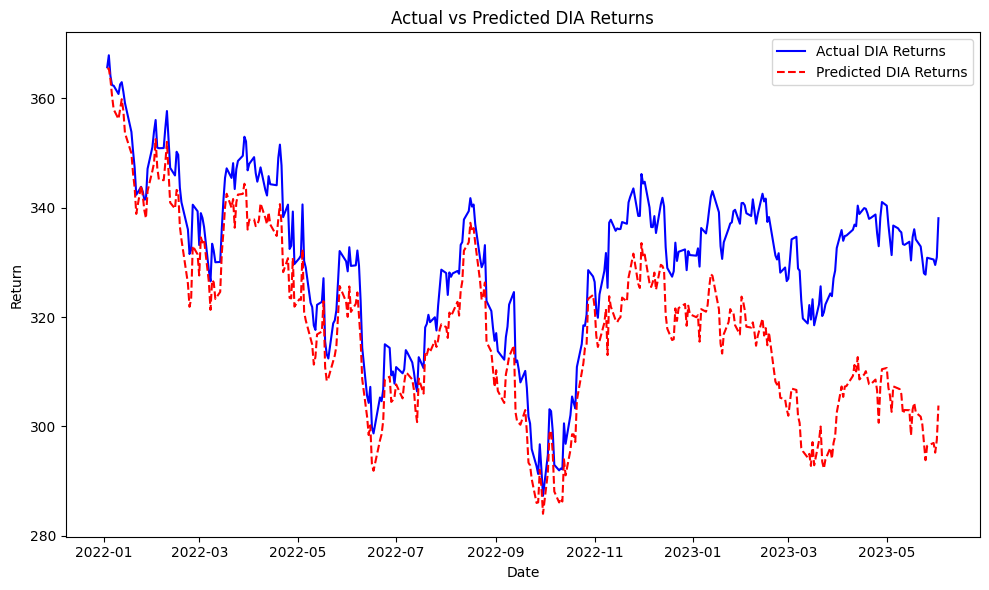

In [41]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 读取数据集
returns = pd.read_csv('dows_daily.csv', index_col=0, parse_dates=True)

# 打印列名确认列名是否正确
print(returns.columns)

# 假设选择的股票列表为：
selected_stocks = ['NKE.N', 'CSCO.OQ', 'DIS.N', 'INTC.OQ', 'HD.N', 'UNH.N', 'MSFT.OQ', 'HON.OQ', 'CRM.N', 'IBM.N', 'MMM.N', 'AAPL.OQ', 'CAT.N', 'V.N', 'TRV.N']

# 检查选择的股票列是否在数据中
if all(stock in returns.columns for stock in selected_stocks):
    # 创建训练集和测试集（2022-01-01为分割点）
    train_data = returns.loc[returns.index < '2022-01-01']
    test_data = returns.loc[returns.index >= '2022-01-01']

    # 提取DIA的回报（目标变量）
    y_train = train_data['DIA']
    y_test = test_data['DIA']

    # 提取选定股票的回报（自变量）
    X_train = train_data[selected_stocks]
    X_test = test_data[selected_stocks]

    # 为回归模型添加常数项（截距项）
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # 拟合线性回归模型
    model = sm.OLS(y_train, X_train).fit()

    # 打印模型摘要
    print(model.summary())

    # 在测试集上进行预测
    y_pred = model.predict(X_test)

    # 评估模型：计算均方误差和R²
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared: {r2:.4f}")

    # 可视化实际值与预测值的对比
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label="Actual DIA Returns", color='blue')
    plt.plot(y_test.index, y_pred, label="Predicted DIA Returns", color='red', linestyle='--')
    plt.title('Actual vs Predicted DIA Returns')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("选择的股票列名不在数据中，请检查列名。")


## Task 3 - Augment the Dataset with Bootstrapped Alphas and Fit again the Linear Predictive Models (40 points)

In this task, we explore the concept of bootstrapped alphas and their role in predictive modeling. Bootstrapped alphas are used as proxy trading signals for real alphas that can be practically obtained. These signals are correlated with future returns and can play the role of good predictors in the predictive modeling process. Don't use the excess returns with respect to a daily risk-free rate for this task, but use the plain returns instead when you have to calculate the boostrapped alphas.

We define bootstrapped alphas $\alpha_t$ as per the formula below:

$$\alpha_{i,t} := \rho_{\text{boot}} r_{i,t+1} + \sqrt{1 - \rho_{\text{boot}}^{2}} z_{i,t}$$

where:
- $r_{i,t+1}$ represents the next period return of the traded security $i$, which is given to you.
- $z_{i,t} \sim \mathbb{N}(0,\sigma^{2})$ is a randomly drawn scalar associated for each company $i$, which is not given and you have to sample. When sampling, ensure that each sampled vector is independent of the other since you have to draw samples for each company you will use as regressors. The number of companies stays the same that you used in the previous task and that you have selected by fitting the CAPM model in task 1.
- $\sigma^{2}_{i}$ is an estimate of the true conditional variance of the security $i$, which you have to calculate based on the given returns. Note that you have to calculate those variances on the train set only. Use the same cutoff applied in the previous task to define what the training set is.
- $\rho_{\text{boot}} \in [-1,1]$ is a correlation coefficient, which you have to set equal to 0.25.

In this setting, the parameter $\rho_{\text{boot}}$ artificially regulates the strength of the trading signal you create. We remark that regressing the bootstrapped alpha $\alpha_t$ on the future returns $r_{t+1}$ results in an $R^2$ equal to $\rho^2$.

The equation above formalizes the calculation of the boostrapped alpha for a single security while you will have more than one security. Try to make your calculations as efficient as possible by computing them simultaneously. It is possible by using calculations between pandas dataframe. Remember that $z_{i,t} \sim \mathcal{N}(0,\sigma^{2}_{i})$ can be calculated as $z_{i,t} = \sqrt{\sigma^{2}_{i}}u_{i,t}$ where $u_{i,t} \sim \mathcal{N}(0,1)$. 

Once you calculate the boostrapped alphas, repeat the linear predictive forecasting exercise as in the previous task. This time you will use the boostrapped alphas as predictors, while you will keep the same target as before, the index returns. In other words, the target stays the same as in the previous task (future returns for DIA) by looking at the equation below. Still, the predictors change from the current returns of the constituents to the alpha bootstrap you have calculated.

$$ Y_{t+1} = \beta_0 + \beta_1 X_{1,t} + \beta_2 X_{2,t} + \ldots + \beta_k X_{k,t} + \varepsilon_{t} $$

To ensure reproducibility, please set the random seed to 42. Don't use another seed, and remember to set it. Avoiding to follow these guidelines will result in point deductions.

**Motivation behind the task**

In the dynamic and complex world of financial markets, predictive modeling is a potent tool to decipher underlying patterns and trends that govern security prices. Coming up with good predictors for a certain set of assets is a complicated task that is not necessarily the purpose of this assignment. The concept of bootstrapped alphas, as delineated in this exercise, emerges as a sophisticated method to engineer artificial trading signals that can potentially enhance the predictive power of financial models. It is equivalent to assuming that we have a way to predict the future returns of the index constituents. Look at the alpha bootstrap equation to understand why we are talking about future returns by looking at what the prices indicate.

The utilization of bootstrapped alphas is grounded in the mathematical formulation provided, where the alpha ($\alpha_{i,t}$) for a security $i$ at time $t$ is constructed using a combination of the next period return of the security ($r_{i,t+1}$) and a stochastic component ($z_{i,t}$) drawn from a normal distribution. This formulation allows for the incorporation of both deterministic and random elements, thereby mimicking the inherent uncertainty and volatility observed in financial markets.

By setting the correlation coefficient ($\rho_{\text{boot}}$) to 0.25, we are essentially moderating the influence of the artificial trading signal, ensuring that it does not overwhelmingly dictate the behavior of the bootstrapped alphas. This parameter, therefore, serves as a tuning knob, allowing us to control the strength of the trading signal and, consequently, its predictive power. However, you have to keep this parameter fixed for this exercise, as indicated by the prompt.

The subsequent step of employing these bootstrapped alphas as predictors in a linear predictive forecasting model is an exercise to highlight how well one can expect to forecast index returns, given a good way to predict future returns for the constituents. By replacing the current returns of the constituents with the calculated bootstrapped alphas, we are essentially enhancing the model with artificially generated yet statistically grounded signals that can potentially unveil deeper insights into the market dynamics.

**Grading Criteria**

- **Data Preparation (30 points)**: Points will be awarded for preparing the data appropriately for the modeling task.

- **Predictive Regression Model Building (5 points)**: Points will be awarded based on the correctness and completeness of the regression model built using selected stocks' boostrapped alpha and the index return.
- **Model Evaluation (5 points)**: Points will be awarded based on the proper choice of evaluation metric.

Columns in the dataset: Index(['DIA', 'GS.N', 'NKE.N', 'CSCO.OQ', 'JPM.N', 'DIS.N', 'INTC.OQ', 'MRK.N',
       'CVX.N', 'AXP.N', 'VZ.N', 'HD.N', 'WBA.OQ', 'MCD.N', 'UNH.N', 'KO.N',
       'JNJ.N', 'MSFT.OQ', 'HON.OQ', 'CRM.N', 'PG.N', 'IBM.N', 'MMM.N',
       'AAPL.OQ', 'WMT.N', 'CAT.N', 'AMGN.OQ', 'V.N', 'TRV.N', 'BA.N'],
      dtype='object')
               DIA    GS.N  NKE.N  CSCO.OQ  JPM.N   DIS.N  INTC.OQ      MRK.N  \
Date                                                                            
2017-06-02  211.91  213.31  52.98    31.98  82.64  107.18    36.32  62.427347   
2017-06-05  211.86  213.99  53.01    31.76  82.79  106.52    36.34  62.045937   
2017-06-06  211.37  214.53  52.48    31.56  82.96  105.50    36.13  61.664526   
2017-06-07  211.72  215.78  53.23    31.61  83.91  105.92    36.26  61.082876   
2017-06-08  211.86  218.76  53.20    31.61  84.95  104.32    36.48  60.262843   

             CVX.N  AXP.N  ...   PG.N       IBM.N   MMM.N  AAPL.OQ  WMT.N  \
Date    

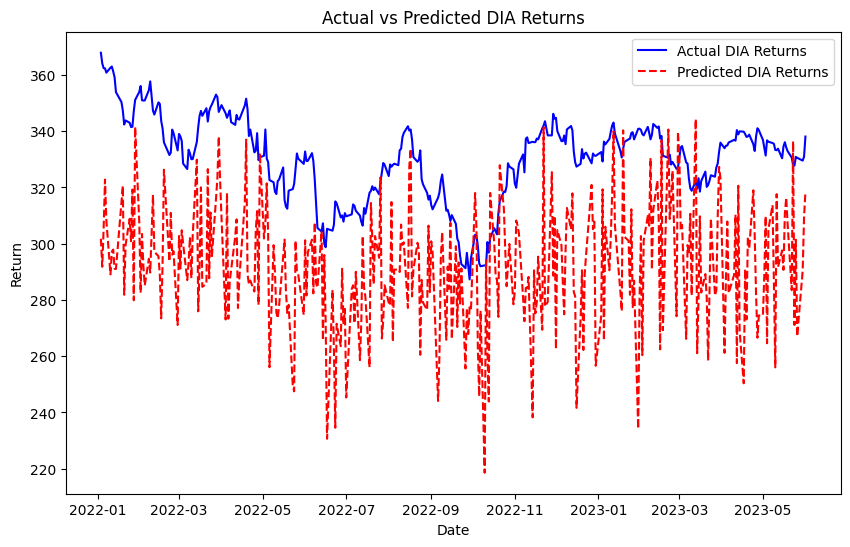

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 设置随机种子
np.random.seed(42)

# 读取数据
returns = pd.read_csv("dows_daily.csv", index_col="Date", parse_dates=True)

# 查看数据的列名和前几行，确保列名匹配
print("Columns in the dataset:", returns.columns)
print(returns.head())

# 根据实际的列名选择股票（注意查看实际列名）
selected_stocks =['NKE.N', 'CSCO.OQ', 'DIS.N', 'INTC.OQ', 'HD.N', 'UNH.N', 'MSFT.OQ', 'HON.OQ', 'CRM.N', 'IBM.N', 'MMM.N', 'AAPL.OQ', 'CAT.N', 'V.N', 'TRV.N']

# 确保选择的列在数据中
returns = returns[selected_stocks + ['DIA']]  # 加入'DIA'作为目标变量

# 查看数据
print(returns.head())

# 计算每只股票的条件方差 (sigma^2) 使用训练集数据
train_data = returns.loc[:'2021-12-31']  # 训练集：2021年12月31日之前的数据
sigma_squared = train_data[selected_stocks].var()

# 设置bootstrap的相关系数
rho_boot = 0.25

# 计算bootstrapped alphas
def compute_bootstrapped_alpha(r_t_plus_1, sigma_squared, rho_boot):
    # 生成标准正态分布的随机变量u
    u = np.random.normal(0, 1, r_t_plus_1.shape)
    # 计算bootstrapped alpha
    alpha = rho_boot * r_t_plus_1 + np.sqrt(1 - rho_boot**2) * np.sqrt(sigma_squared) * u
    return alpha

# 获取未来一天的收益
r_t_plus_1 = returns[selected_stocks].shift(-1)

# 计算bootstrapped alphas
bootstrapped_alphas = {}
for stock in selected_stocks:
    bootstrapped_alphas[stock] = compute_bootstrapped_alpha(r_t_plus_1[stock], sigma_squared[stock], rho_boot)

# 将计算得到的bootstrapped alphas添加到数据框
bootstrapped_alphas_df = pd.DataFrame(bootstrapped_alphas, index=r_t_plus_1.index)

# 准备训练数据和测试数据
train_data = bootstrapped_alphas_df.loc[:'2021-12-31']  # 训练集数据
test_data = bootstrapped_alphas_df.loc['2022-01-01':]  # 测试集数据
y_train = returns.loc[train_data.index, 'DIA'].shift(-1).dropna()  # DIA未来一天的收益作为目标变量
y_test = returns.loc[test_data.index, 'DIA'].shift(-1).dropna()

# 对训练集和测试集的对齐
train_data = train_data.loc[y_train.index]
test_data = test_data.loc[y_test.index]

# 训练回归模型
regressor = LinearRegression()
regressor.fit(train_data, y_train)

# 对测试集进行预测
y_pred = regressor.predict(test_data)

# 计算模型评估指标 (比如均方误差)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# 可视化实际值与预测值
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="Actual DIA Returns", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted DIA Returns", color="red", linestyle="--")
plt.title("Actual vs Predicted DIA Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.show()
